<h1>SAw on a Single Image</h1>

Loading packages/data

In [1]:
from noise_functions import add_spnoise, add_noise
import numpy as np 
from functions import *
import structures as st
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from skimage.restoration import denoise_tv_chambolle

# Construct a tf.data.Dataset
(train, test), info = tfds.load(
    'mnist',
    #split=['train', 'test'],
    split = ['train[:70%]', 'train[70%:]'],
    shuffle_files=True,
    as_supervised=True,
    
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

train = train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train = train.cache()
train = train.shuffle(info.splits['train'].num_examples)
LN = int(300)
train = train.batch(LN)
train = train.prefetch(tf.data.AUTOTUNE)

LN_test = int(30)
test = test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(LN_test)
test = test.cache()
test = test.prefetch(tf.data.AUTOTUNE)

for example in train.take(1):
    image, label = 1 - example[0], example[1]

2025-03-31 18:50:45.034054: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-31 18:50:51.395521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [2]:
from noise_functions import add_spnoise, add_noise
dataset = []
noise_level = np.sqrt(0.05)
prob = 1

noisies = []
for i, img in enumerate(image):
    noisy = add_spnoise(img.numpy().reshape(28,28).copy(), noise_level, prob).reshape(28,28)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.numpy().reshape(28,28)
    im = (im - im.min())/(im.max() - im.min())
    dataset.append([img.numpy().reshape(28,28), noisy])
    noisies.append(noisy)
        

dataset_test = []
noisies_test = []
for i, img in enumerate(image):
    noisy = add_spnoise(img.numpy().reshape(28,28).copy(), noise_level, prob).reshape(28,28)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.numpy().reshape(28,28)
    im = (im - im.min())/(im.max() - im.min())
    dataset_test.append([img.numpy().reshape(28,28), noisy])
    noisies_test.append(noisy)
    
dataset = dataset[0:300]

def f(v, xi, gamma, ui, L):
    return 0.5 * np.linalg.norm(div(v) + xi) ** 2 + np.trace(L.T @ gamma.reshape(28,28)) * TV(ui) 
    
def g(v, gamma, L, verbose):
    mx = 0 
    for i in range(28):
        for j in range(28):
            vec = np.array([v[0,i,j],v[1,i,j]])
            norm = np.linalg.norm(vec)
            scale = np.trace(L.T @ gamma.reshape(28,28))
            if vec.any() > scale:
                mx += 1 
    if mx == 0:
        return 0 
    else:
        return 10000000

Training on a Single Image:

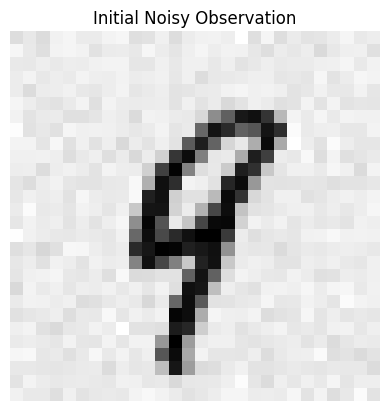

In [3]:
s = 0
noise_level =  np.sqrt(0.001)
noisy = noisies[s]
true_image = dataset[s][0]
noisy = add_spnoise(true_image.copy(), noise_level, prob)

plt.figure()
plt.title('Initial Noisy Observation')
plt.imshow(noisy, cmap = 'grey')
plt.axis('off')
plt.show()

100 iterations complete
200 iterations complete
300 iterations complete
400 iterations complete
500 iterations complete
600 iterations complete
700 iterations complete
800 iterations complete
900 iterations complete
1000 iterations complete


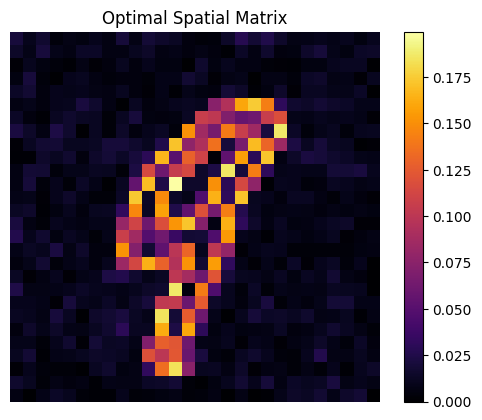

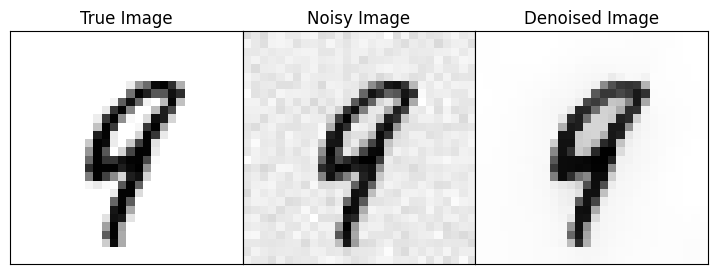

In [4]:
L = 10 * make_spd_matrix(28)
for s in range(28):
    for t in range(28):
        L[s,t] = max(L[s,t], 1)
L_tilde = L
k = 0
max_iterations = 1000
v = np.random.random(size = im_dual(noisy).shape)

kappa = 10
l = 10

errors = []
rec_error = []
Ls = [L]
digs = []
bottom = 1
theta = 1

ID = im_dual(noisy)
gamma = 0 * noisy
for i in range(28):
    for j in range(28):
        gamma[i,j] = np.linalg.norm(np.array([ID[0, i, j], ID[1,i,j]]), 2)
gamma = np.array(gamma).reshape(28*28)

while k < max_iterations and abs(theta) > 1e-9:
    tv = TV(true_image)
    Xi = (1/kappa) * (tv - TV(div(v) + noisy)) * gamma.reshape(28, 28)
    L_tilde = L - Xi
    for i in range(28):
        for j in range(28):
            if L_tilde[i,j] <0:
                L_tilde[i,j] = 0
                            
    scale = np.dot(gamma, L_tilde.reshape(28 * 28))
    
    v_tilde = 0 * v
    v_div = div(v)
    z = im_dual(v_div + noisy)
    for i in range(28):
        for j in range(28):
            vec = np.array([z[0,i,j], z[1,i,j]])
            norm = np.linalg.norm(vec, 2)
            if norm > 0:
                for p in range(2):
                    if v_tilde[p, i, j] != 0:
                        v_tilde[p, i, j] = (z[p, i, j]/norm) * scale 
    
    nabla_v = im_dual(div(v) + noisy)
    v_component = -np.trace(nabla_v[0].T @ (v - v_tilde)[0]) - np.trace(nabla_v[1].T @ (v - v_tilde)[1])
    L_component = TV(true_image) * np.trace((L - L_tilde).T @ gamma.reshape(28,28))
    
    top = v_component + L_component 
    bottom = l * np.linalg.norm(L - L_tilde, 'fro') ** 2 
    if bottom < 1e-6:
        break
    theta = min(1, top/bottom)

    L = L + theta * (L_tilde - L)
    v = v + theta * (v_tilde - v)
    
    Ls.append(L)

    if (k + 1) % int(0.1 * max_iterations) == 0:
        print(f'{k + 1} iterations complete')
    k += 1
    
R = np.sqrt(np.linalg.eig(L.T @ L)[0].max().real)
plt.figure()
plt.imshow(-L/R, cmap = 'inferno')
plt.title('Optimal Spatial Matrix')
plt.colorbar()
plt.axis('off')

w = np.trace(L.T @ gamma.reshape(28, 28))
R = np.sqrt(np.linalg.eig(L.T @ L)[0].max().real)
w = w/R
denoised_img = denoise_tv_chambolle(noisy, abs(1/w))

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0, wspace=0))
axes[0].imshow(true_image, cmap = 'grey')
axes[0].set_title('True Image')
axes[1].imshow(noisy, cmap = 'grey')
axes[1].set_title('Noisy Image')
axes[2].imshow(denoised_img, cmap = 'grey')
axes[2].set_title('Denoised Image')
plt.show()